k近傍法でレコメンデーションの仕組みを構築する
データはkaggleから。
https://www.kaggle.com/CooperUnion/anime-recommendations-database

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [3]:
ratings = pd.read_csv('datasets/rating.csv')
anime = pd.read_csv('datasets/anime.csv')

In [6]:
# データ確認
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [7]:
# データ確認
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [11]:
anime.sort_values('members', ascending=False)
# デスノートが人気らしい
# 進撃の巨人が次いで2位

,anime_id,name,genre,type,episodes,rating,members
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
86,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
804,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
159,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796
19,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
445,10620,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Super...",TV,26,8.07,657190
131,4224,Toradora!,"Comedy, Romance, School, Slice of Life",TV,25,8.45,633817


In [13]:
# anime.describe()
round(anime.describe(), 2)
# 歯抜けデータあり
# データrangeが広い

,anime_id,rating,members
count,12294.00,12064.00,12294.00
mean,14058.22,6.47,18071.34
std,11455.29,1.03,54820.68
min,1.00,1.67,5.00
25%,3484.25,5.88,225.00
50%,10260.50,6.57,1550.00
75%,24794.50,7.18,9437.00
max,34527.00,10.00,1013917.00


In [15]:
round(ratings.describe(), 2)
# -1のrateとはいかに

,user_id,anime_id,rating
count,7813737.00,7813737.00,7813737.00
mean,36727.96,8909.07,6.14
std,20997.95,8883.95,3.73
min,1.00,1.00,-1.00
25%,18974.00,1240.00,6.00
50%,36791.00,6213.00,7.00
75%,54757.00,14093.00,9.00
max,73516.00,34519.00,10.00


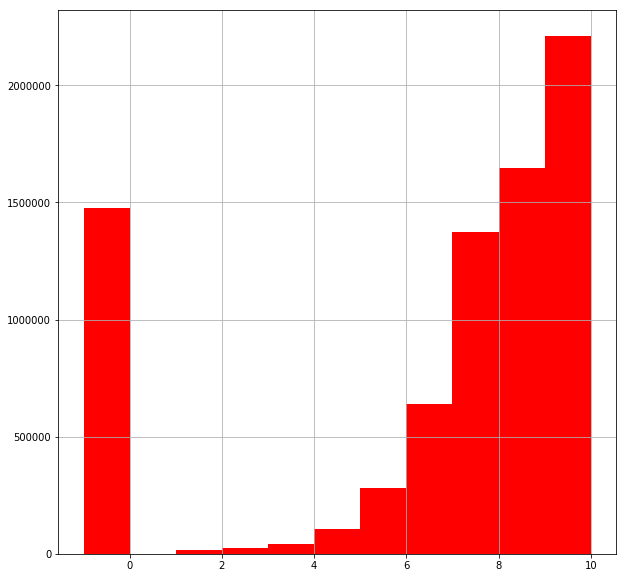

In [21]:
%matplotlib inline
# ヒストグラム
ratings['rating'].hist(bins=11, figsize=(10, 10), color='red')
# -1のデータがたくさんある

In [22]:
# 前処理する
anime = anime[anime['members'] > 10000]

In [24]:
# 歯抜けデータの確認
anime.isnull().sum()

anime_id     0
name         0
genre        2
type         4
episodes     0
rating      43
members      0
dtype: int64

In [25]:
anime = anime.dropna()

In [29]:
# rateが0より小さいものは無視する
# ratingが0以上のみ残す
ratings = ratings[ratings.rating >= 0]

In [32]:
# animeとratingsをマージする
# SQL like?
mergeddf = ratings.merge(anime, left_on='anime_id', right_on='anime_id', suffixes= ['_user', ''])

mergeddf.head()

,user_id,anime_id,rating_user,name,genre,type,episodes,rating,members
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
1,3,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
2,5,8074,2,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
3,12,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
4,14,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892


In [33]:
# マージしたデータの確認
round(mergeddf.describe(), 2)

,user_id,anime_id,rating_user,rating,members
count,5957004.00,5957004.00,5957004.00,5957004.00,5957004.00
mean,36665.80,9023.38,7.87,7.74,196030.78
std,21030.91,8920.21,1.54,0.62,191317.96
min,1.00,1.00,1.00,2.37,10005.00
25%,18911.00,1195.00,7.00,7.35,57029.00
50%,36534.00,6500.00,8.00,7.74,130689.00
75%,54851.00,14345.00,9.00,8.17,271484.00
max,73516.00,34240.00,10.00,9.37,1013917.00


In [34]:
# 使わないカラムをおとす
mergeddf = mergeddf[['user_id', 'name', 'rating_user']]
mergeddf = mergeddf.drop_duplicates(['user_id', 'name'])

mergeddf.head()

,user_id,name,rating_user
0,1,Highschool of the Dead,10
1,3,Highschool of the Dead,6
2,5,Highschool of the Dead,2
3,12,Highschool of the Dead,6
4,14,Highschool of the Dead,6


In [36]:
# ユーザが評価していないデータは0埋め
anime_pivot = mergeddf.pivot(index='name', columns='user_id', values='rating_user').fillna(0)
anime_pivot_sparse = csr_matrix(anime_pivot.values)

In [38]:
anime_pivot.head(10)

user_id,1,2,3,5,7,8,9,10,11,12,...,73507,73508,73509,73510,73511,73512,73513,73514,73515,73516
name,,,,,,,,,,,,,,,,,,,,,
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Memoire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Movie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Returner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Trilogy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Gift,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Intermezzo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Liminality,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Quantum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# 
knn = NearestNeighbors(n_neighbors=9, algorithm='brute', metric='cosine')
model_knn = knn.fit(anime_pivot_sparse)

In [62]:
def search_anime(name):
    results = anime_pivot[anime_pivot.index.str.contains(name)].index[0:]
    counter = 1
    for i in results:
        print(counter, i)
        counter += 1
    

In [63]:
search_anime('Death')

1 Death Billiards
2 Death Note
3 Death Note Rewrite
4 Death Parade
5 Digimon Xros Wars: Aku no Death General to Nanatsu no Oukoku
6 Neon Genesis Evangelion: Death &amp; Rebirth


In [64]:
search_anime('Hai')

1 Hai to Gensou no Grimgar
2 Hai to Gensou no Grimgar Special
3 Haibane Renmei
4 Haikyuu!!
5 Haikyuu!! Movie 1: Owari to Hajimari
6 Haikyuu!! Movie 2: Shousha to Haisha
7 Haikyuu!! OVA
8 Haikyuu!! Second Season
9 Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou
10 Haiyore! Nyaruko-san
11 Haiyore! Nyaruko-san F
12 Haiyore! Nyaruko-san W
13 Haiyore! Nyaruko-san W OVA
14 Haiyore! Nyaruko-san: Yasashii Teki no Shitome-kata
15 Haiyoru! Nyaruani
16 Haiyoru! Nyaruani: Remember My Love(craft-sensei)
17 Yuru Yuri San☆Hai!


In [73]:
# 類似度、距離を算出
Anime = 'Kimi no Na wa.'
distance, indice = model_knn.kneighbors(anime_pivot.iloc[anime_pivot.index== Anime].values.reshape(1,-1),n_neighbors=11)

for i in range(0, len(distance.flatten())):
    if  i == 0:
        print('Recommendations if you like the anime {0}:\n'.format(anime_pivot[anime_pivot.index== Anime].index[0]))
    else:
        print('{0}: {1} with distance: {2}'.format(i,anime_pivot.index[indice.flatten()[i]],distance.flatten()[i]))

Recommendations if you like the anime Kimi no Na wa.:

1: Boku dake ga Inai Machi with distance: 0.6855242894481091
2: Re:Zero kara Hajimeru Isekai Seikatsu with distance: 0.6968551384446042
3: Shigatsu wa Kimi no Uso with distance: 0.703281384251974
4: ReLIFE with distance: 0.7191316277184874
5: One Punch Man with distance: 0.7426460533821271
6: Charlotte with distance: 0.7434996132820642
7: Noragami Aragoto with distance: 0.7486936229508915
8: Shokugeki no Souma with distance: 0.7585646506908518
9: Yahari Ore no Seishun Love Comedy wa Machigatteiru. Zoku with distance: 0.7602916580493286
10: Noragami with distance: 0.7612671872707739
